In [1]:
# Install the professional diffusion library
!pip install denoising-diffusion-pytorch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 4.0 MB/s eta 0:00:00


In [2]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from denoising_diffusion_pytorch.classifier_free_guidance import Unet, GaussianDiffusion

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 128  # Reduced from 256 to save memory
NUM_CLASSES = 4   # HGC, LGC, NST, NTL
TIMESTEPS = 1000
BATCH_SIZE = 4    # Reduced from 16 to avoid OOM
EPOCHS = 100

LABEL_MAP = {"HGC": 0, "LGC": 1, "NST": 2, "NTL": 3}
print(f"Using device: {DEVICE}")

# Clear cache if using GPU
if DEVICE == "cuda":
    torch.cuda.empty_cache()

Using device: cuda


In [4]:
# Load and prepare data
TRAIN_CSV = "/kaggle/input/ebt-dataset/train.csv"
train_df = pd.read_csv(TRAIN_CSV)
train_df["label"] = train_df["tissue type"].map(LABEL_MAP)
train_df = train_df[["HLY", "label"]].dropna().reset_index(drop=True)
train_df["label"] = train_df["label"].astype(int)

print("Rows:", len(train_df))
print(train_df["label"].value_counts().sort_index())

Rows: 1224
label
0    309
1    482
2    346
3     87
Name: count, dtype: int64


In [5]:
class BladderDataset(Dataset):
    def __init__(self, df, image_size=256):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["HLY"]
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
        
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        label = int(self.df.iloc[idx]["label"])
        return image, label

dataset = BladderDataset(train_df, IMAGE_SIZE)
print(f"Dataset size: {len(dataset)}")

Dataset size: 1224


In [6]:
# Create the Unet with classifier-free guidance (smaller architecture)
model = Unet(
    dim=32,  # Reduced from 64 to save memory
    num_classes=NUM_CLASSES,
    cond_drop_prob=0.1,  # 10% of time train unconditionally (for classifier-free guidance)
    dim_mults=(1, 2, 4),  # Reduced from (1, 2, 4, 8) to save memory
    channels=3,
    attn_dim_head=32,
    attn_heads=4
).to(DEVICE)

# Wrap in GaussianDiffusion
diffusion = GaussianDiffusion(
    model,
    image_size=IMAGE_SIZE,
    timesteps=TIMESTEPS,
    sampling_timesteps=250,  # Faster sampling with DDIM
    objective='pred_v',  # v-parameterization (better than noise prediction)
    beta_schedule='cosine',  # Cosine schedule works better than linear
    min_snr_loss_weight=True,  # Improves training stability
    min_snr_gamma=5
).to(DEVICE)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 2,915,619


In [7]:
# Training loop
from torch.utils.data import DataLoader
from tqdm import tqdm

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=False)
optimizer = torch.optim.AdamW(diffusion.parameters(), lr=1e-4)

loss_history = []

for epoch in range(EPOCHS):
    diffusion.train()
    epoch_losses = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for images, labels in pbar:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Forward pass - the library handles everything internally
        loss = diffusion(images, classes=labels)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(diffusion.parameters(), 1.0)
        optimizer.step()
        
        epoch_losses.append(loss.item())
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        # Clear cache periodically to avoid memory buildup
        if DEVICE == "cuda":
            torch.cuda.empty_cache()
    
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Avg Loss: {avg_loss:.4f}")

# Save final model
torch.save(diffusion.state_dict(), "/kaggle/working/diffusion_final.pth")
print("Training complete!")

Epoch 1/100: 100%|██████████| 306/306 [00:50<00:00,  6.12it/s, loss=0.0530]


Epoch 1/100 - Avg Loss: 0.0864


Epoch 2/100: 100%|██████████| 306/306 [00:48<00:00,  6.27it/s, loss=0.0306]


Epoch 2/100 - Avg Loss: 0.0265


Epoch 3/100: 100%|██████████| 306/306 [00:48<00:00,  6.27it/s, loss=0.0165]


Epoch 3/100 - Avg Loss: 0.0197


Epoch 4/100: 100%|██████████| 306/306 [00:48<00:00,  6.27it/s, loss=0.0198]


Epoch 4/100 - Avg Loss: 0.0166


Epoch 5/100: 100%|██████████| 306/306 [00:48<00:00,  6.29it/s, loss=0.0216]


Epoch 5/100 - Avg Loss: 0.0132


Epoch 6/100: 100%|██████████| 306/306 [00:48<00:00,  6.29it/s, loss=0.0070]


Epoch 6/100 - Avg Loss: 0.0115


Epoch 7/100: 100%|██████████| 306/306 [00:48<00:00,  6.28it/s, loss=0.0093]


Epoch 7/100 - Avg Loss: 0.0107


Epoch 8/100: 100%|██████████| 306/306 [00:48<00:00,  6.30it/s, loss=0.0060]


Epoch 8/100 - Avg Loss: 0.0096


Epoch 9/100: 100%|██████████| 306/306 [00:48<00:00,  6.30it/s, loss=0.0072]


Epoch 9/100 - Avg Loss: 0.0090


Epoch 10/100: 100%|██████████| 306/306 [00:48<00:00,  6.29it/s, loss=0.0052]


Epoch 10/100 - Avg Loss: 0.0086


Epoch 11/100: 100%|██████████| 306/306 [00:48<00:00,  6.30it/s, loss=0.0109]


Epoch 11/100 - Avg Loss: 0.0081


Epoch 12/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0066]


Epoch 12/100 - Avg Loss: 0.0073


Epoch 13/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0117]


Epoch 13/100 - Avg Loss: 0.0075


Epoch 14/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0087]


Epoch 14/100 - Avg Loss: 0.0069


Epoch 15/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0071]


Epoch 15/100 - Avg Loss: 0.0073


Epoch 16/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0052]


Epoch 16/100 - Avg Loss: 0.0068


Epoch 17/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0117]


Epoch 17/100 - Avg Loss: 0.0068


Epoch 18/100: 100%|██████████| 306/306 [00:48<00:00,  6.28it/s, loss=0.0069]


Epoch 18/100 - Avg Loss: 0.0065


Epoch 19/100: 100%|██████████| 306/306 [00:48<00:00,  6.30it/s, loss=0.0046]


Epoch 19/100 - Avg Loss: 0.0064


Epoch 20/100: 100%|██████████| 306/306 [00:48<00:00,  6.30it/s, loss=0.0059]


Epoch 20/100 - Avg Loss: 0.0063


Epoch 21/100: 100%|██████████| 306/306 [00:48<00:00,  6.27it/s, loss=0.0055]


Epoch 21/100 - Avg Loss: 0.0060


Epoch 22/100: 100%|██████████| 306/306 [00:48<00:00,  6.29it/s, loss=0.0042]


Epoch 22/100 - Avg Loss: 0.0060


Epoch 23/100: 100%|██████████| 306/306 [00:48<00:00,  6.30it/s, loss=0.0050]


Epoch 23/100 - Avg Loss: 0.0060


Epoch 24/100: 100%|██████████| 306/306 [00:48<00:00,  6.29it/s, loss=0.0042]


Epoch 24/100 - Avg Loss: 0.0061


Epoch 25/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0039]


Epoch 25/100 - Avg Loss: 0.0059


Epoch 26/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0064]


Epoch 26/100 - Avg Loss: 0.0057


Epoch 27/100: 100%|██████████| 306/306 [00:48<00:00,  6.26it/s, loss=0.0024]


Epoch 27/100 - Avg Loss: 0.0058


Epoch 28/100: 100%|██████████| 306/306 [00:48<00:00,  6.29it/s, loss=0.0028]


Epoch 28/100 - Avg Loss: 0.0057


Epoch 29/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0074]


Epoch 29/100 - Avg Loss: 0.0055


Epoch 30/100: 100%|██████████| 306/306 [00:48<00:00,  6.29it/s, loss=0.0016]


Epoch 30/100 - Avg Loss: 0.0054


Epoch 31/100: 100%|██████████| 306/306 [00:48<00:00,  6.30it/s, loss=0.0045]


Epoch 31/100 - Avg Loss: 0.0055


Epoch 32/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0075]


Epoch 32/100 - Avg Loss: 0.0055


Epoch 33/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0025]


Epoch 33/100 - Avg Loss: 0.0053


Epoch 34/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0076]


Epoch 34/100 - Avg Loss: 0.0054


Epoch 35/100: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0039]


Epoch 35/100 - Avg Loss: 0.0055


Epoch 36/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0049]


Epoch 36/100 - Avg Loss: 0.0053


Epoch 37/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0056]


Epoch 37/100 - Avg Loss: 0.0050


Epoch 38/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0053]


Epoch 38/100 - Avg Loss: 0.0052


Epoch 39/100: 100%|██████████| 306/306 [00:48<00:00,  6.29it/s, loss=0.0065]


Epoch 39/100 - Avg Loss: 0.0053


Epoch 40/100: 100%|██████████| 306/306 [00:48<00:00,  6.30it/s, loss=0.0065]


Epoch 40/100 - Avg Loss: 0.0051


Epoch 41/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0044]


Epoch 41/100 - Avg Loss: 0.0051


Epoch 42/100: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0043]


Epoch 42/100 - Avg Loss: 0.0050


Epoch 43/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0065]


Epoch 43/100 - Avg Loss: 0.0051


Epoch 44/100: 100%|██████████| 306/306 [00:48<00:00,  6.28it/s, loss=0.0028]


Epoch 44/100 - Avg Loss: 0.0049


Epoch 45/100: 100%|██████████| 306/306 [00:48<00:00,  6.30it/s, loss=0.0011]


Epoch 45/100 - Avg Loss: 0.0051


Epoch 46/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0073]


Epoch 46/100 - Avg Loss: 0.0052


Epoch 47/100: 100%|██████████| 306/306 [00:48<00:00,  6.29it/s, loss=0.0029]


Epoch 47/100 - Avg Loss: 0.0047


Epoch 48/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0017]


Epoch 48/100 - Avg Loss: 0.0048


Epoch 49/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0047]


Epoch 49/100 - Avg Loss: 0.0048


Epoch 50/100: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0034]


Epoch 50/100 - Avg Loss: 0.0048


Epoch 51/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0046]


Epoch 51/100 - Avg Loss: 0.0048


Epoch 52/100: 100%|██████████| 306/306 [00:48<00:00,  6.30it/s, loss=0.0063]


Epoch 52/100 - Avg Loss: 0.0048


Epoch 53/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0021]


Epoch 53/100 - Avg Loss: 0.0049


Epoch 54/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0052]


Epoch 54/100 - Avg Loss: 0.0047


Epoch 55/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0036]


Epoch 55/100 - Avg Loss: 0.0047


Epoch 56/100: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0033]


Epoch 56/100 - Avg Loss: 0.0049


Epoch 57/100: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0047]


Epoch 57/100 - Avg Loss: 0.0048


Epoch 58/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0049]


Epoch 58/100 - Avg Loss: 0.0049


Epoch 59/100: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0033]


Epoch 59/100 - Avg Loss: 0.0048


Epoch 60/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0078]


Epoch 60/100 - Avg Loss: 0.0047


Epoch 61/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0020]


Epoch 61/100 - Avg Loss: 0.0047


Epoch 62/100: 100%|██████████| 306/306 [00:48<00:00,  6.30it/s, loss=0.0039]


Epoch 62/100 - Avg Loss: 0.0046


Epoch 63/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0039]


Epoch 63/100 - Avg Loss: 0.0044


Epoch 64/100: 100%|██████████| 306/306 [00:48<00:00,  6.29it/s, loss=0.0019]


Epoch 64/100 - Avg Loss: 0.0043


Epoch 65/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0072]


Epoch 65/100 - Avg Loss: 0.0046


Epoch 66/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0078]


Epoch 66/100 - Avg Loss: 0.0046


Epoch 67/100: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0018]


Epoch 67/100 - Avg Loss: 0.0045


Epoch 68/100: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0028]


Epoch 68/100 - Avg Loss: 0.0045


Epoch 69/100: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0020]


Epoch 69/100 - Avg Loss: 0.0044


Epoch 70/100: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0046]


Epoch 70/100 - Avg Loss: 0.0046


Epoch 71/100: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0055]


Epoch 71/100 - Avg Loss: 0.0044


Epoch 72/100: 100%|██████████| 306/306 [00:48<00:00,  6.30it/s, loss=0.0040]


Epoch 72/100 - Avg Loss: 0.0045


Epoch 73/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0051]


Epoch 73/100 - Avg Loss: 0.0044


Epoch 74/100: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0042]


Epoch 74/100 - Avg Loss: 0.0044


Epoch 75/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0067]


Epoch 75/100 - Avg Loss: 0.0045


Epoch 76/100: 100%|██████████| 306/306 [00:48<00:00,  6.29it/s, loss=0.0034]


Epoch 76/100 - Avg Loss: 0.0045


Epoch 77/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0060]


Epoch 77/100 - Avg Loss: 0.0044


Epoch 78/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0017]


Epoch 78/100 - Avg Loss: 0.0044


Epoch 79/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0048]


Epoch 79/100 - Avg Loss: 0.0043


Epoch 80/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0065]


Epoch 80/100 - Avg Loss: 0.0043


Epoch 81/100: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0029]


Epoch 81/100 - Avg Loss: 0.0043


Epoch 82/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0045]


Epoch 82/100 - Avg Loss: 0.0044


Epoch 83/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0031]


Epoch 83/100 - Avg Loss: 0.0043


Epoch 84/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0019]


Epoch 84/100 - Avg Loss: 0.0043


Epoch 85/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0025]


Epoch 85/100 - Avg Loss: 0.0042


Epoch 86/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0074]


Epoch 86/100 - Avg Loss: 0.0043


Epoch 87/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0049]


Epoch 87/100 - Avg Loss: 0.0042


Epoch 88/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0075]


Epoch 88/100 - Avg Loss: 0.0043


Epoch 89/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0040]


Epoch 89/100 - Avg Loss: 0.0042


Epoch 90/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0039]


Epoch 90/100 - Avg Loss: 0.0047


Epoch 91/100: 100%|██████████| 306/306 [00:48<00:00,  6.33it/s, loss=0.0027]


Epoch 91/100 - Avg Loss: 0.0042


Epoch 92/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0030]


Epoch 92/100 - Avg Loss: 0.0042


Epoch 93/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0015]


Epoch 93/100 - Avg Loss: 0.0041


Epoch 94/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0043]


Epoch 94/100 - Avg Loss: 0.0044


Epoch 95/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0025]


Epoch 95/100 - Avg Loss: 0.0042


Epoch 96/100: 100%|██████████| 306/306 [00:48<00:00,  6.32it/s, loss=0.0033]


Epoch 96/100 - Avg Loss: 0.0043


Epoch 97/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0021]


Epoch 97/100 - Avg Loss: 0.0042


Epoch 98/100: 100%|██████████| 306/306 [00:48<00:00,  6.34it/s, loss=0.0031]


Epoch 98/100 - Avg Loss: 0.0044


Epoch 99/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0012]


Epoch 99/100 - Avg Loss: 0.0042


Epoch 100/100: 100%|██████████| 306/306 [00:48<00:00,  6.31it/s, loss=0.0041]


Epoch 100/100 - Avg Loss: 0.0042
Training complete!


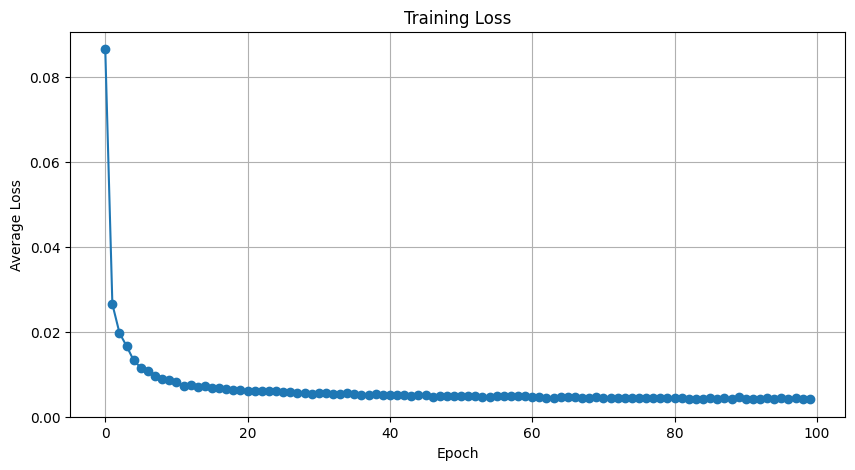

In [8]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss')
plt.grid(True)
plt.savefig('/kaggle/working/training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Load trained model (if restarting kernel)
diffusion.load_state_dict(torch.load("/kaggle/working/diffusion_final.pth"))
diffusion.eval()
print("Model loaded!")

Model loaded!


In [10]:
# Generate samples with classifier-free guidance
# Higher cond_scale = stronger conditioning on class label

class_id = 3  # NTL
num_samples = 40  # Reduced from 40 to avoid OOM during generation

# Clear cache before generation
if DEVICE == "cuda":
    torch.cuda.empty_cache()

# Generate with strong guidance
classes = torch.full((num_samples,), class_id, device=DEVICE, dtype=torch.long)
generated_images = diffusion.sample(
    classes=classes,
    cond_scale=6.0,  # Guidance strength (higher = more class-specific)
    rescaled_phi=0.7
)

print(f"Generated {num_samples} images for class {list(LABEL_MAP.keys())[class_id]}")

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Generated 40 images for class NTL


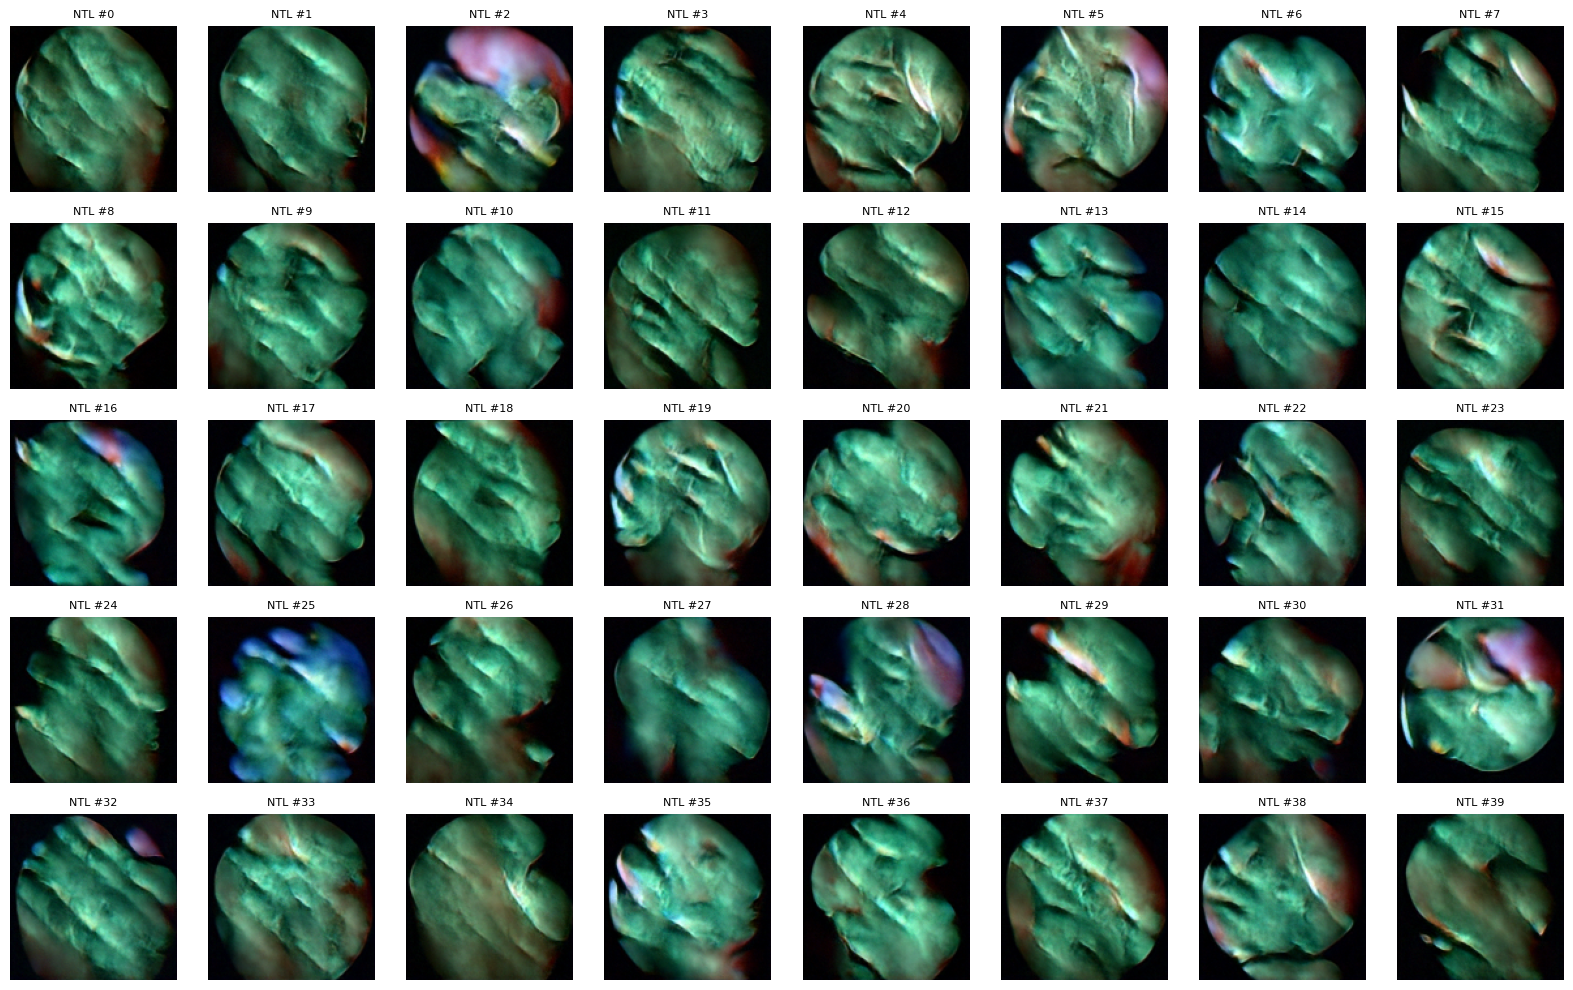

In [11]:
# Display generated images in a grid
fig, axes = plt.subplots(5, 8, figsize=(16, 10))  # 5x8 = 40 images

for i in range(num_samples):
    img = generated_images[i].cpu().permute(1, 2, 0).numpy()
    img = img.clip(0, 1)
    axes[i // 8, i % 8].imshow(img)
    axes[i // 8, i % 8].axis('off')
    axes[i // 8, i % 8].set_title(f'{list(LABEL_MAP.keys())[class_id]} #{i}', fontsize=8)

plt.tight_layout()
plt.savefig('/kaggle/working/generated_samples.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Save individual generated images
os.makedirs("/kaggle/working/generated_images", exist_ok=True)

from torchvision.utils import save_image
for i, img in enumerate(generated_images):
    save_image(img, f"/kaggle/working/generated_images/{list(LABEL_MAP.keys())[class_id]}_{i:03d}.png")

print(f"Saved {num_samples} images to /kaggle/working/generated_images/")

Saved 40 images to /kaggle/working/generated_images/
